In [1]:
import os
import pandas as pd
import json
from glob import glob
from tqdm.auto import tqdm
import obspy
import obspy.taup
import warnings
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
warnings.filterwarnings("ignore")

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download test data

In [2]:
os.system("curl -L -O https://github.com/AI4EPS/EPS207_Observational_Seismology/releases/download/fm_data/fm_data.zip && unzip -q -o fm_data.zip")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3137k  100 3137k    0     0  6648k      0 --:--:-- --:--:-- --:--:-- 6648k


0

In [3]:
data_path = 'fm_data'
# data_path = "./QuakeFlow/slurm/local/demo"
with open(f"{data_path}/stations.json", "r") as f:
    stations = json.load(f)

stations = pd.DataFrame.from_dict(stations, orient='index')
stations["station_id"] = stations.index
events = pd.read_csv(f"{data_path}/catalog.csv", parse_dates=['time'])
events['time'] = events['time'].dt.tz_localize(None)
if "event_id" in events.columns:
    events.rename(columns={"event_id": "event_index"}, inplace=True)
events.set_index('event_index', inplace=True)

picks = pd.read_csv(f"{data_path}/picks.csv", parse_dates=['phase_time'])


In [4]:
stations[:3]

,network,station,location,instrument,component,sensitivity,latitude,longitude,elevation_m,depth_km,x_km,y_km,z_km,provider,station_id
CI.CCC..BH,CI,CCC,,BH,ENZ,"[627368000.0, 627368000.0, 627368000.0]",35.52495,-117.36453,670.0,-0.67,12.65,-19.968,-0.67,SCEDC,CI.CCC..BH
CI.CCC..HH,CI,CCC,,HH,ENZ,"[627368000.0, 627368000.0, 627368000.0]",35.52495,-117.36453,670.0,-0.67,12.65,-19.968,-0.67,SCEDC,CI.CCC..HH
CI.CCC..HN,CI,CCC,,HN,ENZ,"[213979.0, 214322.0, 213808.0]",35.52495,-117.36453,670.0,-0.67,12.65,-19.968,-0.67,SCEDC,CI.CCC..HN


In [5]:
events[:3]

,time,magnitude,latitude,longitude,depth_km,agency,x_km,y_km,z_km
event_index,,,,,,,,,
ci38443095,2019-07-04 17:02:55.340,3.98,35.70817,-117.50367,10.60,ci,0.030,0.351,10.60
ci38443111,2019-07-04 17:09:20.090,2.49,35.70767,-117.50133,10.97,ci,0.241,0.296,10.97
ci38443119,2019-07-04 17:11:32.850,0.63,35.70550,-117.49750,11.20,ci,0.588,0.055,11.20


In [6]:
picks[:3]

,station_id,phase_index,phase_time,phase_score,phase_type,phase_polarity,phase_amplitude,event_index
0,CI.CLC..BH,3042,2019-07-04 17:51:49.778,0.499,P,-0.660,0.000235,ci38443287
1,CI.CLC..HN,3045,2019-07-04 17:51:49.808,0.650,P,-0.925,0.000571,ci38443287
2,CI.CLC..HH,3045,2019-07-04 17:51:49.808,0.714,P,-0.916,0.000583,ci38443287


### Stations and events

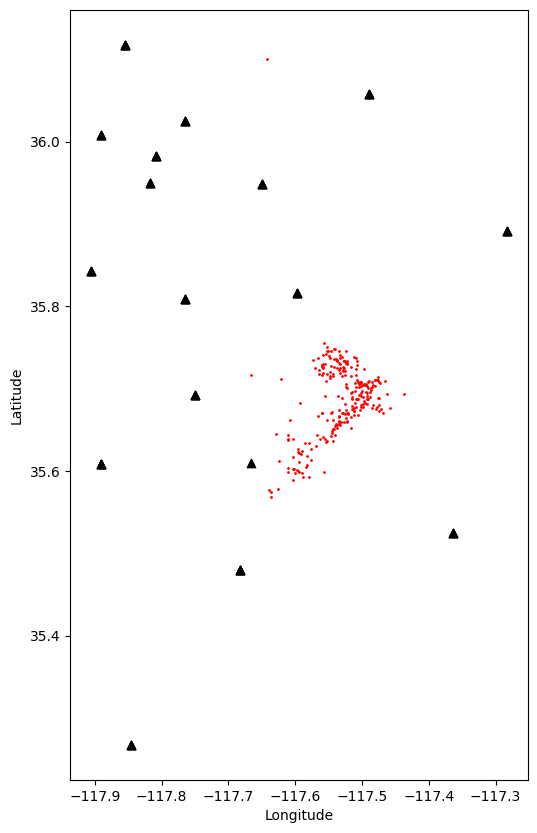

In [7]:
plt.figure(figsize=(10, 10))
plt.scatter(stations['longitude'], stations['latitude'], color='k', marker='^')
plt.scatter(events['longitude'], events['latitude'], s=1, color='r', marker='o')
plt.gca().set_aspect(1.0/np.cos(np.pi/180*stations['latitude'].mean()))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Convert the station list format

In [8]:
hash_path = "hash_results"
if not os.path.exists(hash_path):
    os.makedirs(hash_path)

# merge picks and events based on event_index
picks = picks.merge(events, on="event_index", suffixes=("_pick", "_event"))
picks = picks.merge(stations, on="station_id", suffixes=("_pick", "_station"))

In [9]:
# "LOCSRCE station LATLON latitude longitdue depth elevation"
station_fmt = "LOCSRCE {} LATLON {:.4f} {:.4f} 0 {}\n"
# the file containing station information
stafile = f'./{hash_path}/stations.nll'
with open(stafile,'w') as fp:
    for _, station in stations.iterrows():
        fp.writelines(station_fmt.format(station['station_id'], station['latitude'], station['longitude'], station['elevation_m']/1000))

In [10]:
!head ./hash_results/stations.nll

LOCSRCE CI.CCC..BH LATLON 35.5249 -117.3645 0 0.67
LOCSRCE CI.CCC..HH LATLON 35.5249 -117.3645 0 0.67
LOCSRCE CI.CCC..HN LATLON 35.5249 -117.3645 0 0.67
LOCSRCE CI.CLC..BH LATLON 35.8157 -117.5975 0 0.775
LOCSRCE CI.CLC..HH LATLON 35.8157 -117.5975 0 0.775
LOCSRCE CI.CLC..HN LATLON 35.8157 -117.5975 0 0.775
LOCSRCE CI.DTP..BH LATLON 35.2674 -117.8458 0 0.908
LOCSRCE CI.DTP..HH LATLON 35.2674 -117.8458 0 0.908
LOCSRCE CI.DTP..HN LATLON 35.2674 -117.8458 0 0.908
LOCSRCE CI.JRC2..BH LATLON 35.9825 -117.8089 0 1.469


### Convert polarity and S/P picks

In [11]:
# year month day hour minute seconds evla evlo evdp errh errz evid
eventlinefmt = "{:04d} {:02d} {:02d} {:02d} {:02d} {:05.2f} {:010.6f} {:010.6f} {:09.6f} {:05.2f} {:05.2f} {:}\n"
# station polarity "qp" S/P_ratio
stationlinefmt = "{} {:1s} 0 {:08.3f}\n"

picks_by_event = picks.groupby("event_index")
for event_index, picks_ in tqdm(picks_by_event):
    # the file being created which should contain event information, polarity and S/P data
    polfile = f'{hash_path}/{event_index}.pol.hash'

    event_info = events.loc[event_index]
    with open(polfile, 'w') as pf:
        # write event information into the file
        pf.writelines(eventlinefmt.format(event_info['time'].year, event_info['time'].month, event_info['time'].day, event_info['time'].hour, event_info['time'].minute, event_info['time'].second+1e-6*event_info['time'].microsecond, event_info['latitude'], event_info['longitude'], event_info['depth_km'], 0.0, 0.0, event_index))

        # loop for all station that have picks
        # if no P pick, continue the next loop
        # if P pick exists and its polarity prob exceeds a certain value
        # assign 'U','u','+' or 'D','d','-', respectively, otherwise 'x'
        # if both P and S picks exist, divide S by P amplitude as S/P ratio
        # if no S pick, set the ratio to zero
        picks_by_station = picks_.groupby("station_id")
        for station_id, picks__ in picks_by_station:
            if 'P' not in picks__['phase_type'].values:
                continue
            P_polarity = picks__[picks__['phase_type'] == 'P']['phase_polarity'].values[0]
            if P_polarity < -0.3:
                polarity = '-'
            elif P_polarity > 0.3:
                polarity = '+'
            else:
                polarity = 'x'
            if 'S' in picks__['phase_type'].values:
                S_polarity = picks__[picks__['phase_type'] == 'S']['phase_polarity'].values[0]
                S_amplitdue = picks__[picks__['phase_type'] == 'S']['phase_amplitude'].values[0]
                P_amplitdue = picks__[picks__['phase_type'] == 'P']['phase_amplitude'].values[0]
                SP_ratio = S_amplitdue/P_amplitdue
            else:
                SP_ratio = 0
            # write polarity and S/P ratio data at each station into the file
            pf.writelines(stationlinefmt.format(station_id, polarity, SP_ratio))

100%|██████████| 251/251 [00:08<00:00, 28.34it/s]


In [12]:
!head ./hash_results/ci37230908.pol.hash

2019 07 04 18 57 42.06 035.713330 -117.548170 02.020000 00.00 00.00 ci37230908
CI.CCC..BH + 0 0001.686
CI.CCC..HH + 0 0001.780
CI.CCC..HN + 0 0002.448
CI.CLC..BH - 0 0001.000
CI.CLC..HH - 0 0001.000
CI.CLC..HN - 0 0001.821
CI.DTP..HH - 0 0000.000
CI.DTP..HN x 0 0000.000
CI.JRC2..BH x 0 0001.155


### Prepare input files for HASH

In [13]:
velocity_model = """0.00  4.74000
1.00  5.01000
2.00  5.35000
3.00  5.71000
4.00  6.07000
5.00  6.17000
6.00  6.27000
7.00  6.34000
8.00  6.39000
30.00 7.80000
"""
with open(f'{hash_path}/ca.vel', 'w') as fp:
    fp.writelines(velocity_model)

# loop for all polarity data files
polfiles = glob(f'{hash_path}/*.pol.hash')
# for polfile in tqdm(list(polfiles)):
def run(polfile):
    event_id = os.path.basename(polfile).split('.')[0]
    # the inputfile which should contain input and output files and parameters
    iptfile = f'{hash_path}/{event_id}.inp.hash'
    # the file containing the best solutions
    optfile1 = f'{hash_path}/{event_id}.best.fps'
    # the file containing all solutions
    optfile2 = f'{hash_path}/{event_id}.all.fps'
    # the file containing ray parameters
    optfile3 = f'{hash_path}/{event_id}.rays'
    # the file containing velocity profile
    velfile = f'{hash_path}/ca.vel'
    # Angle increment for grid search
    dang = 1
    # Number of perutbations of take-off angles for different source depths and velocity models
    nmc = 50
    # Maximum number focal mechanisms that match misfit critria to return
    maxout = 20
    # maximum distance to consider (km)
    maxdist = 100
    # number of polarities assumed bad
    nbadpol = 4
    # log10 of uncertainty factor for s/p ratios.
    qbadfac = 0.2
    # Angular distance between different families of focal mechanisms.
    cangle = 45
    # Fraction of focal mechanisms that need to be within cangle to make up a new famlily of focal mechanisms.
    prob_max = 0.2
    # number of velocity models
    nvelmod = 1
    # write these information sequencially into the inputfile
    with open(iptfile, 'w') as ipt:
        ipt.writelines('{}\n{}\n{}\n{}\n{}\n'.format(polfile,stafile,optfile1,optfile2,optfile3))
        ipt.writelines('{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n'.format(dang,nmc,maxout,maxdist,nbadpol,qbadfac,cangle,prob_max))
        ipt.writelines('{}\n{}\n'.format(nvelmod, velfile))
    # run the command
    os.system(f'QuakeFlow/hashpy2/hash/hash_hashpy1D < {iptfile} > hash.log 2>&1')


In [14]:
ncpu = mp.cpu_count()
bpar = tqdm(total=len(polfiles))
with mp.Pool(ncpu) as p:
    for file in polfiles:
        p.apply_async(run, args=(file,), callback=lambda _: bpar.update())
    p.close()
    p.join()

100%|██████████| 755/755 [05:11<00:00,  2.95it/s]

### Check result of a single event

In [15]:
event_id = 'ci37222972'

In [16]:
allmecafile = f'{hash_path}/{event_id}.all.fps'
df_allmeca = pd.read_csv(allmecafile, header=None, delim_whitespace=True)

In [17]:
bestmecafile= f'{hash_path}/{event_id}.best.fps'
df_bestmeca= pd.read_csv(bestmecafile, header=None, delim_whitespace=True)
df_bestmeca

,0,1,2,3,4
0,105,85,-167,15,A


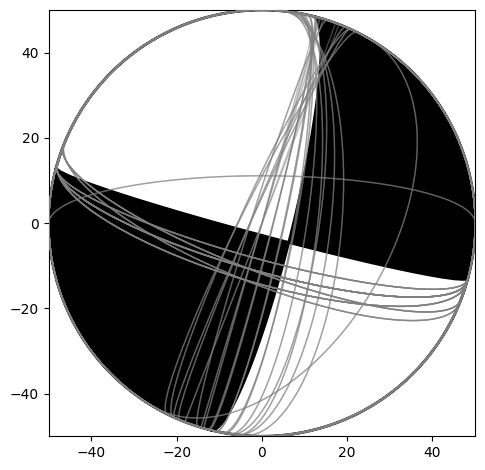

In [18]:
from obspy.imaging.beachball import beach
fig, ax = plt.subplots()
# plot the best one first
strike, dip, rake = df_bestmeca.loc[0].to_numpy()[:3]
bball = beach(fm=[strike, dip, rake],facecolor='k', xy=(0,0), width=100)
ax.add_collection(bball)
# plot all solutions that meet the criterion
for i in df_allmeca.index:
    strike, dip, rake = df_allmeca.loc[i].to_numpy()[:3]
    bball = beach(fm=[strike, dip, rake], linewidth=1, nofill=True, xy=(0,0), width=100, edgecolor='gray', alpha=0.5)
    ax.add_collection(bball)
plt.xlim(-50, 50)
plt.ylim(-50, 50)
ax.set_aspect('equal')
fig.tight_layout()

### Plot focal mechanisms of all earthquakes

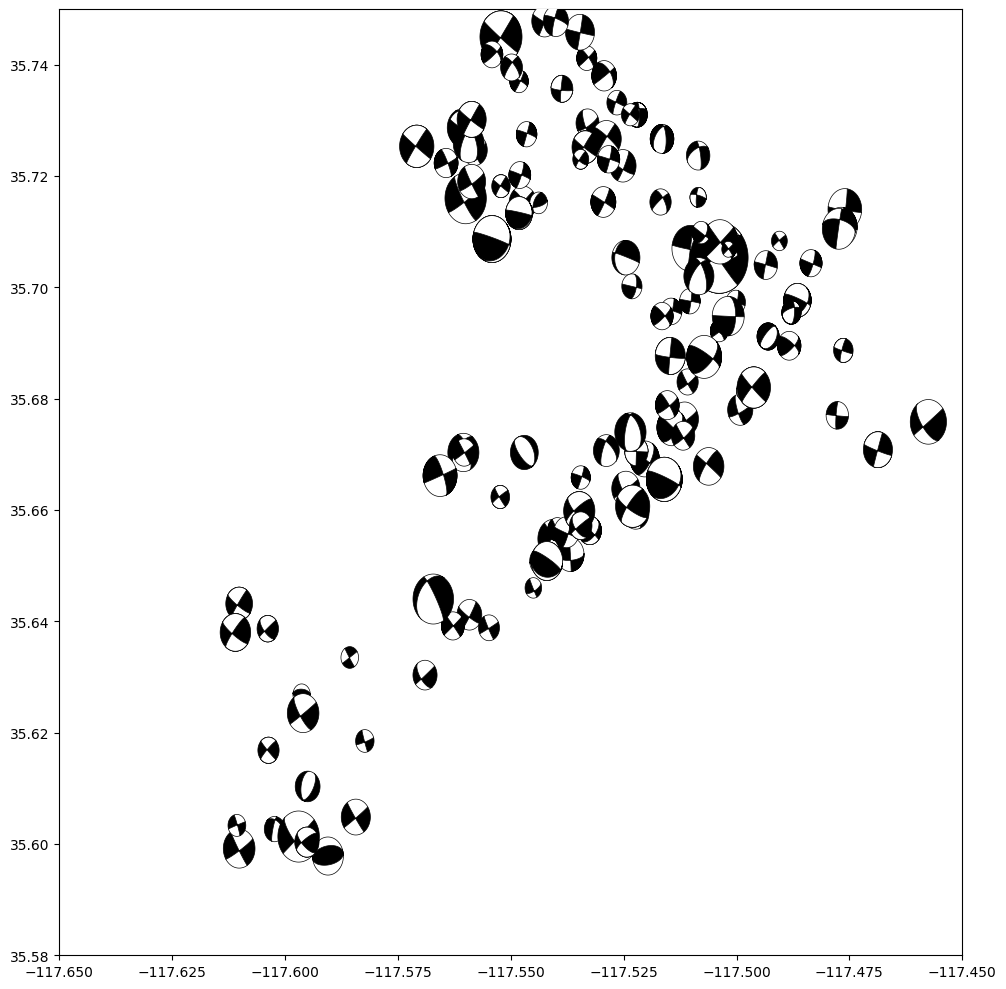

In [20]:
bestmecafiles = glob(f'{hash_path}/*.best.fps')
fig, ax = plt.subplots(figsize=(10, 10))
for bestmecafile in bestmecafiles:
    # get the event information
    event_id = os.path.basename(bestmecafile).split('.')[0]
    evot, mag, evla, evlo, evdp = events.loc[event_id][['time', 'magnitude', 'latitude', 'longitude', 'depth_km']]
    # get strike, dip and rake angles
    df_bestmeca= pd.read_csv(bestmecafile, header=None, delim_whitespace=True)
    strike, dip, rake, RMS, Q = df_bestmeca.loc[0].to_numpy()
    if Q != "A":
        continue
    # plot and change the width/size according to the earthquake magnitude
    bball = beach(fm=[strike, dip, rake], linewidth=0.5, facecolor='k', xy=(evlo,evla), width=mag*2e-3)
    ax.add_collection(bball)
    # ax.annotate(Q, (evlo,evla), (evlo+0.02,evla), arrowprops=dict(facecolor='black', width=0.05, headwidth=0.05))
ax.set_xlim(-117.65, -117.45)
ax.set_ylim(35.58, 35.75)
ax.set_aspect(1.0/np.cos(np.pi/180*stations['latitude'].mean()))
fig.tight_layout()